# Storm water retention basin volume estimation

To compute the basin's water volume, we will use a USGS DEM as the primary dataset, since it provides elevation data for the entire basin surface and also a shapefile representing the water footprint in the bassin. The storm water retention basin is a sink. By filling it at the level of the water footprint, and then comparing the filled elevation to the basin's original elevation, we can determine the volume capacity.

In [1]:
# Import system modules
import arcpy
import os
from arcpy.sa import *

In [2]:
# Set environment settings
arcpy.env.workspace = os.getcwd()
arcpy.env.overwriteOutput = True

In [3]:
# Convert Polygon to Line
# Create variables for the input and output feature classes
in_features = "Water_footprint.shp"
out_feature_class = "Subwatersheds_digitization_Line"

# Run PolygonToLine to convert polygons to lines 
arcpy.PolygonToLine_management(in_features, out_feature_class)

<Result 'C:\\Users\\gaell\\Documents\\Renaldo\\Python_Portfolio\\ESRI\\Volume_calculation\\Subwatersheds_digitization_Line.shp'>

In [4]:
# Add elevation information to the Line 
# Set the local variables
inFeatureClass = "Subwatersheds_digitization_Line"
inSurface = "usgs_dem"
out_property = "Z_MEAN"
method = "BILINEAR"

# Execute the tool
AddSurfaceInformation(inFeatureClass, inSurface, out_property, method)

<geoprocessing server result object at 0x202f2224450>

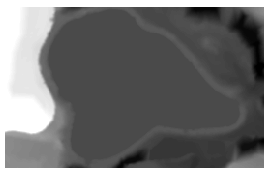

In [5]:
# Fill the Surface
# Water footprint Z value recuperation
fc = "Subwatersheds_digitization_Line"
field = "Z_MEAN"

values = [row[0] for row in arcpy.da.SearchCursor(fc, field)]
values[0]

# Set local variables
inSurfaceRaster = "usgs_dem"
zLimit = values[0]

# Execute FlowDirection
BasinFill = Fill(inSurfaceRaster, zLimit)

# Save the output 
BasinFill.save("usgsfill")

BasinFill

The largest shape represents the retention basin and provides the basin's volume.


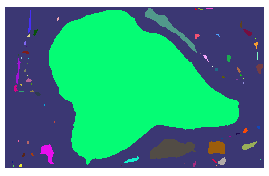

In [6]:
# Cut Fill tool to calculate the volume change between the original DEM and BasinFill layer.
with arcpy.EnvManager(scratchWorkspace=os.getcwd()):
    Basin_cutfill = arcpy.sa.CutFill(
        in_before_surface="usgs_dem",
        in_after_surface="usgfill",
        z_factor=1
    )
    Basin_cutfill.save(os.getcwd()+"\\CutFill_dem")
    
print("The largest shape represents the retention basin and provides the basin's volume.")    
Basin_cutfill    


In [7]:
# Volume value recuperation
fc = "CutFill_dem" 
field = "VOLUME"

val = [field for field in arcpy.da.SearchCursor(fc, field)]

print("The attribute table of the Basin_cutfill layer contains a field, Volume, with volume measurements for each sink. The volume values are all expressed as negative numbers because when we used the Cut Fill tool, we subtracted the higher elevation from the lower. The largest shape corresponds to the min volume.")
min(val)

The attribute table of the Basin_cutfill layer contains a field, Volume, with volume measurements for each sink. The volume values are all expressed as negative numbers because when we used the Cut Fill tool, we subtracted the higher elevation from the lower. The largest shape corresponds to the min volume.


(-38565.1410447,)